#### Aug. 9, 2018 1pm

---

#### Function Definitions

In [1]:
def time_Now():
    import datetime
    import pytz
    utc_now = pytz.utc.localize(datetime.datetime.utcnow())
    pst_now = utc_now.astimezone(pytz.timezone("America/Los_Angeles"))
    return (pst_now)

In [25]:
import itertools 
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label',  fontsize=14)
    plt.xlabel('Predicted label',  fontsize=14)

In [2]:
def plot_model_ROC(model, X_df, y_true, figTitle=None, printMetrics=False, figName=None):
    '''
        Function will plot the Model's ROC curve with several options:
        - alter the fig TITLE
        - APPEND model metrics to the figure
        - SAVE figure as a *.png and a*.pdf file
        
        Function will execute with only 3 of the 6 parameters
        - sklearn model that can give a predict_proba
        - X_df to apply the predict_proba
        - y_true the true values to compute TPR and FPR (T/F positive rates)
    '''
    
    pred = model.predict(X_df)
    y_score = model.predict_proba(X_df)[:,1]

    fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=1)

    plt.figure(figsize=(12,10))
    plt.plot(fpr, tpr, 'o--')
    plt.plot(np.linspace(0,1), np.linspace(0,1), 'k--')
    plt.ylabel("True Positive Rate",  fontsize=14)
    plt.xlabel("False Positive Rate", fontsize=14);
    plt.text(.6, .1, "AUC score: {0:.4f}".format( roc_auc_score(y_test, y_score) ), fontsize=14);
    
    if figTitle:
        plt.title(figTitle)
    else:
        plt.title(str(model))
        
    if printMetrics:
        plt.text(.6, .15, "Accuracy score: {0:.4f}".format( accuracy_score(y_true, pred) ), fontsize=14);
        plt.text(.6, .2, "Precision score: {0:.4f}".format( precision_score(y_true, pred) ), fontsize=14);
        plt.text(.6, .25, "Recall score: {0:.4f}".format( recall_score(y_true, pred) ), fontsize=14);
        plt.text(.6, .3, "F1 score: {0:.4f}".format( f1_score(y_true, pred) ), fontsize=14);

    if figName:
        print("saving..." + figName)
        plt.gcf()
        plt.savefig(figName + '.png')
        plt.savefig(figName + '.pdf')

In [ ]:
def plot_RF_model_ROC(model, X_df, y_true):
    
    y_score = model.predict_proba(X_df)[:,1]

    fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=1)

    plt.figure(figsize=(12,10))
    plt.plot(fpr, tpr, 'o--')
    plt.plot(np.linspace(0,1), np.linspace(0,1), 'k--')
    plt.ylabel("True Positive Rate",  fontsize=14)
    plt.xlabel("False Positive Rate", fontsize=14);
    plt.text(.6, .1, "AUC score: {0:.4f}".format( roc_auc_score(y_test, y_score) ), fontsize=14);

In [3]:
def RF_top_words(RF_model, stop = 50):

    importances = RF_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    indices = indices.reshape(1,n_comps)
    
    important_words = svd.inverse_transform(np.array(indices))

    iw_ind = np.argsort(important_words)[::-1]

    inds = iw_ind[:,:stop].reshape(stop)
    print( np.array(ftrs)[iw_ind[:,:stop].reshape(stop)] )

In [31]:
def RF_feature_importance(forest, X, importances):
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure(figsize=(12,10))
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])

---
### Modified: 

In [4]:
print("Last modified on: ", time_Now())

Last modified on:  2018-08-13 11:54:10.082014-07:00


---

In [5]:
import numpy   as np
import pandas  as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing   import scale, StandardScaler
from sklearn.decomposition   import PCA, TruncatedSVD

import re
import pickle
from nltk.corpus import stopwords

# -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --

In [6]:
%%time

df = pd.read_pickle("newRev_VegCols_US.pkl")

X_df = df.drop(['vegFriendly', 'Vegan', 'Vegetarian'], axis=1)
y_df = df['vegFriendly']

X_df.iloc[:, 5] = X_df['text'].apply( lambda rev: re.sub(r'(\d+)', '', rev) )
X_df.iloc[:, 5] = X_df['text'].apply( lambda rev: rev.replace('_', '') )

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3, random_state=26)

# -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --

CPU times: user 18.3 s, sys: 784 ms, total: 19.1 s
Wall time: 19.1 s


In [7]:
%%time

stopWords = list(stopwords.words('english'))
stopWords.extend(['good', 'excellent', 'best', 'like', 'place', 'really', 'ordered', 'amazing', 'fantastic', 'am', 'pm'])
# 189
stopWords.extend(['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaauuuuuuuuuuuuuuuuggggggggggggggggggg', 'aaaaaaah'])
stopWords.extend(['aaaaaaamazing', 'aaaaaaand', 'aaaaaamazing', 'aaaaahhhh', 'aaaaahhhhhhmazing', 'aaaaahhhhmaaazeballs', 'aaaaamazing', 'aaaaand'])
stopWords.extend(['aaaack', 'aaaamazing', 'aaaammmazziiigggg', 'aaaand', 'aaaarrgh', 'aaah', 'aaahh'])
stopWords.extend(['aaahhhh', 'aaahhhhh', 'aaahhhhmmmaaazzziiiinnnnggg'])
stopWords.extend(['aaammaziiiing', 'aaand', 'aab', 'aaboud', 'aac', 'aachi', 'aadd', 'aaggh', 'aagh', 'aah', 'aahan', 'aahc', 'aahhh'])
stopWords.extend(['aahhhh', 'aahhhhhh', 'aahhhhhhmazing', 'aahhhhhmazing', 'aahhhhmazing', 'aahing', 'aahran'])
# 234
stopWords.extend(['aaaaaaaaaa', 'aaaaaaaaaaaaaand', 'aaaaaaaaaaaaaauthentic', 'aaaaaaaaaaaaaawwwwwwwwwwwwwwwwwwwwww', 'aaaaaaaaaaack', 'aaaaaaaaaaah', 'aaaaaaaaaand', 'aaaaaaaaargh', 'aaaaaaaack', 'aaaaaaaahhhhhhhhh', 'aaaaaaaamazing', 'aaaaaaaand', 'aaaaaaall', 'aaaaaaamaaaaazing', 'aaaaaaammmmazing', 'aaaaaahhhh', 'aaaaaahhhhh', 'aaaaaahhhhhmazing', 'aaaaaand', 'aaaaaannnddd', 'aaaaaannnndddd', 'aaaaagh', 'aaaaah', 'aaaaahhhhmazing', 'aaaaamaaazing', 'aaaaammmaazzzinnngg', 'aaaaarrrggghh', 'aaaaawful', 'aaaaay', 'aaaagh', 'aaaah', 'aaaahh', 'aaaahhh', 'aaaahhhh', 'aaaahhhhhhh', 'aaaahmazzzing', 'aaaajúa', 'aaaall', 'aaaalllllllll', 'aaaallright', 'aaaammaaazzinnnggg', 'aaaammazzing', 'aaaammmaaaaazzzziiiinnnngggg', 'aaaammmaaazing', 'aaaammmmmmazing', 'aaaamzing', 'aaaandd', 'aaaanddd', 'aaaannnd', 'aaaannnnd', 'aaaanyway', 'aaaawesoooome', 'aaaawwwesome', 'aaaawwwww', 'aaagggrrrrrrrhhhhh', 'aaahahaa', 'aaahhh', 'aaahhhhhhh', 'aaahhhs', 'aaahing', 'aaahmaaaazing', 'aaahmazing', 'aaahs', 'aaaiiiiight', 'aaall', 'aaallll', 'aaalways', 'aaamaazing', 'aaamazing', 'aaammaaazzziinnnngggg', 'aaammazing', 'aaammmazing', 'aaammmazinggggg', 'aaammmmaaazzziinnggg', 'aaannd', 'aaanndd', 'aaannndd', 'aaannnnd', 'aaanyway', 'aaare', 'aaawwee', 'aaawww', 'aaawwwwsome', 'aaay', 'aacross', 'aadbcc', 'aadorbsssssss', 'aagain', 'aahaan', 'aahed', 'aahh', 'aahs', 'aaid', 'aaiight', 'aaiiight', 'aaim', 'aaka', 'aaked', 'aaliyah', 'aall'])
stopWords.extend(['aaaaaaaaaaaaahhhhhhh', 'aaaaaaaaaah', 'aaaaaaaahhhhmazing', 'aaaaaaaawesooooooooooooome', 'aaaaaaggghhh', 'aaaaaah', 'aaaaaawesome', 'aaaaahhh', 'aaaaahhhhhh', 'aaaahhhhhhs', 'aaaajua', 'aaaalmost', 'aaaamazzzzing', 'aaaammaaazzziiingggg', 'aaaarreeeee', 'aaagh', 'aaahed', 'aaahhhmaaaazing', 'aaahhhmazing', 'aaammaazzing', 'aaarghhh', 'aahaha', 'aahhhhhaaaahhhhh'])
# 357 

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.7 ms


In [8]:
%%time
vectorizer = CountVectorizer(stop_words=stopWords, strip_accents = 'ascii' )

# -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --

X_train_term  = vectorizer.fit_transform(X_train['text'])

pickle.dump(vectorizer, open('pkl_tfidf_stpWds_120_1000.p','wb'))

CPU times: user 44.4 s, sys: 408 ms, total: 44.9 s
Wall time: 44.9 s


In [9]:
ftrs = vectorizer.get_feature_names()

# -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --

In [10]:
%%time
n_comps = 120
svd = TruncatedSVD(n_components = n_comps, n_iter=7)

svd_transf = svd.fit(X_train_term)

pickle.dump(svd_transf, open('pkl_svd_120_comp.p','wb'))

X_train_term_svd = svd_transf.transform( X_train_term )

CPU times: user 2min 11s, sys: 9.76 s, total: 2min 20s
Wall time: 1min 33s


In [11]:
%%time
from sklearn.ensemble import RandomForestClassifier

n_trees = 1000
RF_model = RandomForestClassifier(n_jobs=-1, n_estimators = n_trees)

RF_model.fit(X_train_term_svd, y_train)

# pickle.dump(RF_model, open('pkl_rf_1000_trees.p','wb'))

CPU times: user 4h 25min 26s, sys: 5.41 s, total: 4h 25min 31s
Wall time: 33min 22s


---
#### Load Pickled Models

In [12]:
# import pickle
# m_term120_800 = pickle.load(open('pkl_tfidf_stpWds.p','rb'))

# m_svd_120 = pickle.load(open('pkl_svd_120_comp.p','rb'))

# len(m_term120_800.get_stop_words())

# %%time
# X_train_term_svd = m_svd_120.transform( X_train_term )

---

#### Random Forest - Test

In [13]:
%%time
X_test_term = vectorizer.transform(X_test['text'])

CPU times: user 19.6 s, sys: 64 ms, total: 19.7 s
Wall time: 19.7 s


In [14]:
X_test_term.shape

(276901, 137777)

In [15]:
%%time
X_test_term_svd = svd_transf.transform(X_test_term)

CPU times: user 1.26 s, sys: 92 ms, total: 1.36 s
Wall time: 1.35 s


In [16]:
X_test_term_svd.shape

(276901, 120)

In [17]:
%%time
pred = RF_model.predict(X_test_term_svd)

CPU times: user 2min 34s, sys: 128 ms, total: 2min 34s
Wall time: 19.5 s


In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

In [19]:
accuracy_score(y_test, pred)

0.9075301280963233

In [20]:
precision_score(y_test, pred)

0.9870519797335335

In [21]:
recall_score(y_test, pred)

0.5561135486599355

In [22]:
f1_score(y_test, pred)

0.711411665257819

In [23]:
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

        0.0       0.90      1.00      0.94    220150
        1.0       0.99      0.56      0.71     56751

avg / total       0.92      0.91      0.90    276901



Confusion matrix, without normalization


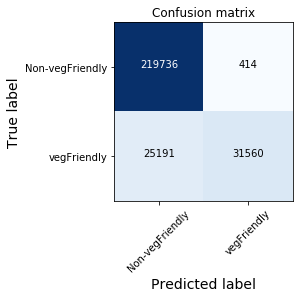

In [26]:
cm = confusion_matrix(y_test, pred)

lbls = ['Non-vegFriendly', 'vegFriendly',]

plot_confusion_matrix(cm, lbls, False)

---

#### Plot RF ROC curve

saving...RF_357StWds_full_countV_SVD


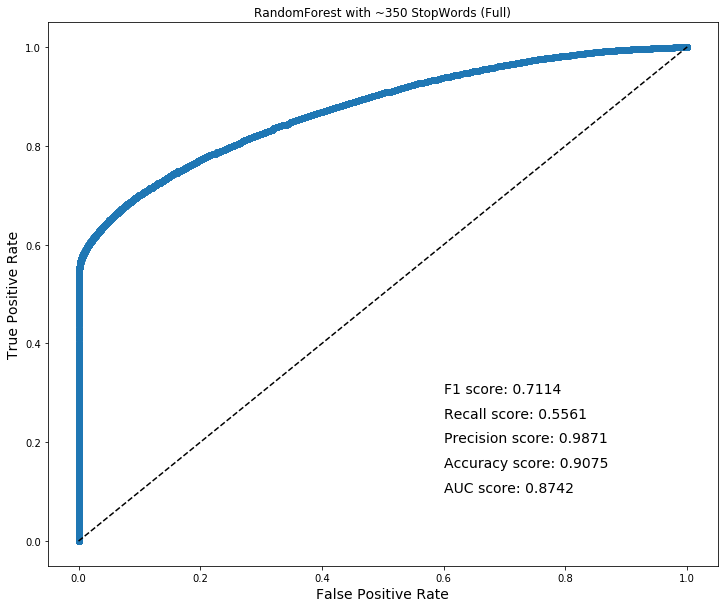

In [29]:
fTitle = 'RandomForest with ~350 StopWords (Full)'
mMetrics = True
fName = 'RF_357StWds_full_countV_SVD'
plot_model_ROC(RF_model, X_test_term_svd, y_test, fTitle, mMetrics, fName)

Feature ranking:
1. feature 41 (0.015749)
2. feature 59 (0.015393)
3. feature 16 (0.014125)
4. feature 42 (0.013958)
5. feature 67 (0.013764)
6. feature 37 (0.013456)
7. feature 2 (0.012065)
8. feature 51 (0.011799)
9. feature 8 (0.011745)
10. feature 40 (0.011589)
11. feature 55 (0.011477)
12. feature 10 (0.011153)
13. feature 0 (0.010681)
14. feature 54 (0.010470)
15. feature 23 (0.010416)
16. feature 7 (0.010252)
17. feature 30 (0.010055)
18. feature 57 (0.009974)
19. feature 18 (0.009534)
20. feature 53 (0.009517)
21. feature 4 (0.009469)
22. feature 9 (0.009390)
23. feature 26 (0.009378)
24. feature 15 (0.009373)
25. feature 29 (0.009321)
26. feature 17 (0.009162)
27. feature 1 (0.009157)
28. feature 49 (0.009132)
29. feature 5 (0.009103)
30. feature 3 (0.009064)
31. feature 33 (0.008976)
32. feature 117 (0.008740)
33. feature 64 (0.008592)
34. feature 50 (0.008589)
35. feature 32 (0.008565)
36. feature 22 (0.008550)
37. feature 68 (0.008357)
38. feature 35 (0.008263)
39. feature 

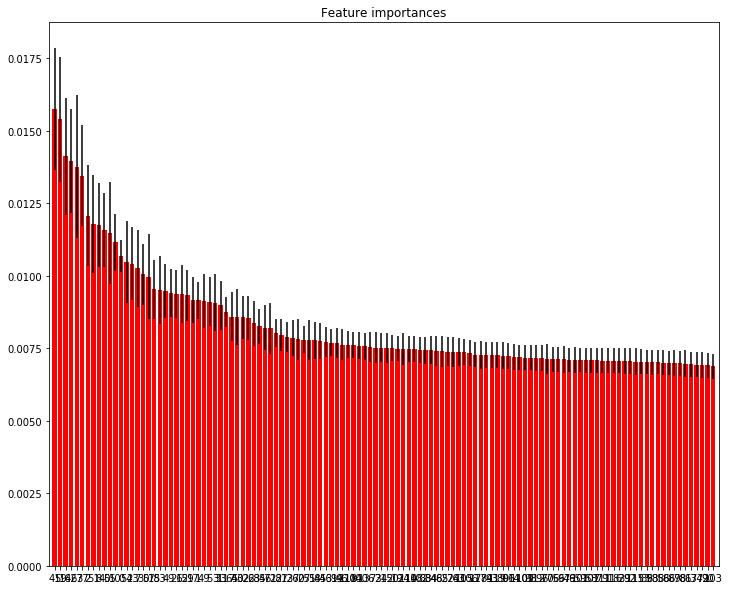

In [32]:
importances = RF_model.feature_importances_
RF_feature_importance(RF_model, X_test_term_svd, importances)

In [34]:
pickle.dump(RF_model, open('pkl_rf_120c_1000_trees.p','wb'))

In [33]:
RF_top_words(RF_model)

['know' 'flavor' 'since' 'friendly' 'first' 'dishes' 'dish' 'say'
 'burrito' 'get' 'times' 'could' 'made' 'table' 'area' 'got' 'think'
 'definitely' 'husband' 'sweet' 'last' 'fresh' 'two' 'waitress' 'small'
 'drinks' 'family' 'still' 'visit' 'back' 'day' 'thai' 'favorite' 'eat'
 'cheese' 'love' 'every' 'sushi' 'never' 'super' 'cream' 'menu' 'went'
 'make' 'many' 'drink' 'tasty' 'breakfast' 'special' 'pretty']
